# Clustering Fire Safety Deficiencies in Nursing Homes

## Introduction

We've all heard horror stores from nursing homes of abuse and neglect.  We've even seen some empirical evidence of negligence and underfunding with nursing homes accounting for over 40% of the death toll to Covid-19 in the US.  It's not a huge leap to assume some corner may have been cut elsewhere in the system and this project takes a look into clustering these nursing homes and the fire-safety deficiencies that have been recorded since 2014.

## Analysis

### Data Cleaning

#### Calling reference libraries and importing data [here](https://catalog.data.gov/dataset/fire-safety-deficiencies-61a6d)

In [116]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

from prince import MCA
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn import manifold
from sklearn.metrics import make_scorer, silhouette_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering, KMeans

In [3]:
fs_data = pd.read_csv("data/Fire_Safety_Deficiencies.csv")
display(
    fs_data.head(3),
    fs_data.info(),
    fs_data.isna().mean().sort_values(ascending=False)
)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 161999 entries, 0 to 161998
Data columns (total 21 columns):
 #   Column                   Non-Null Count   Dtype 
---  ------                   --------------   ----- 
 0   Federal Provider Number  161999 non-null  object
 1   Provider Name            161999 non-null  object
 2   Provider Address         161999 non-null  object
 3   Provider City            161999 non-null  object
 4   Provider State           161999 non-null  object
 5   Provider Zip Code        161999 non-null  int64 
 6   Survey Date              161999 non-null  object
 7   Survey Type              161999 non-null  object
 8   Deficiency Prefix        161999 non-null  object
 9   Deficiency Category      161999 non-null  object
 10  Deficiency Description   161999 non-null  object
 11  Deficiency Tag Number    161999 non-null  int64 
 12  Tag Version              161999 non-null  object
 13  Scope Severity Code      161999 non-null  object
 14  Deficiency Corrected

,Federal Provider Number,Provider Name,Provider Address,Provider City,Provider State,Provider Zip Code,Survey Date,Survey Type,Deficiency Prefix,Deficiency Category,...,Deficiency Tag Number,Tag Version,Scope Severity Code,Deficiency Corrected,Correction Date,Inspection Cycle,Standard Deficiency,Complaint Deficiency,Location,Processing Date
0,366402,WILLOW RIDGE OF MENNONITE HOME COMMUNITIES OF ...,101 WILLOW RIDGE DRIVE,BLUFFTON,OH,45817,05/01/2019,Fire Safety,K,Smoke Deficiencies,...,353,New,F,"Deficient, Provider has date of correction",06/20/2019,1,True,N,NaN,04/01/2020
1,015075,SUMMERFORD NURSING HOME INC,4087 HIGHWAY 31 SOUTHWEST,FALKVILLE,AL,35622,09/27/2017,Fire Safety,K,Smoke Deficiencies,...,351,New,D,"Deficient, Provider has date of correction",10/09/2017,3,True,N,NaN,04/01/2020
2,015116,SIGNATURE HEALTHCARE OF WHITESBURG GARDENS,105 TEAKWOOD DRIVE SW,HUNTSVILLE,AL,35801,09/06/2018,Fire Safety,K,Miscellaneous Deficiencies,...,761,New,F,"Deficient, Provider has date of correction",10/11/2018,2,True,N,"105 TEAKWOOD DRIVE SW HUNTSVILLE, AL 35801 (34...",04/01/2020


None

Location                   0.065161
Correction Date            0.008741
Processing Date            0.000000
Deficiency Prefix          0.000000
Provider Name              0.000000
Provider Address           0.000000
Provider City              0.000000
Provider State             0.000000
Provider Zip Code          0.000000
Survey Date                0.000000
Survey Type                0.000000
Deficiency Description     0.000000
Deficiency Category        0.000000
Deficiency Tag Number      0.000000
Tag Version                0.000000
Scope Severity Code        0.000000
Deficiency Corrected       0.000000
Inspection Cycle           0.000000
Standard Deficiency        0.000000
Complaint Deficiency       0.000000
Federal Provider Number    0.000000
dtype: float64

In [70]:
display(
    fs_data['Deficiency Category'].value_counts(normalize=True, ascending=True).head(5),
    fs_data['Deficiency Tag Number'].value_counts(normalize=True, ascending=True).head(5),
    fs_data['Scope Severity Code'].value_counts(normalize=True, ascending=True).head(5),
    fs_data['Deficiency Corrected'].value_counts(normalize=True, ascending=True).head(5),
)

Laboratories Deficiencies                             0.000031
Smoking Regulations Deficiencies                      0.000556
Interior Deficiencies                                 0.001074
Illumination and Emergency Power Deficiencies         0.001309
Medical Gases and Anesthetizing Areas Deficiencies    0.001401
Name: Deficiency Category, dtype: float64

931    0.000006
257    0.000006
16     0.000006
19     0.000006
109    0.000006
Name: Deficiency Tag Number, dtype: float64

I    0.000006
H    0.000006
G    0.000025
J    0.000049
K    0.000074
Name: Scope Severity Code, dtype: float64

Waiver has been granted                          0.000037
Past Non-Compliance                              0.000179
Fire Safety Evaluation Survey                    0.000222
Deficient, Provider has no plan of correction    0.008648
Deficient, Provider has plan of correction       0.033210
Name: Deficiency Corrected, dtype: float64

### EDA

Looking through the columns, `Deficiency Description` is freeform text and for the purposes of this project will not provide any useful information as most of the data has already been encoded in other columns.  The `Survey Type` column only has the value of `'Fire Safety'` and columns with zero variance provide no useful information in creating clusters.  From the dataset and through some research online, the `Deficiency Tag Number` doesn't seem to have any significance.  I could not find any documentation on the values for that feature.  

### Handling Nulls

Thankfully there aren't many nulls to begin with so let's look at `Location` first.  It appears that the `Location` column contains the address as well as the Lat/Long coordinates where Lat/Long were not provided as separate columns.  I may encode lat/long for the null values but for the time being let's drop it.

For the `Correction Date` column, we see that where the null values are contain all of the "Deficient, Provider has no plan of correction" values in the Deficiency Corrected column so we can't drop on either axis or we may lose a factor of significance either way.  I will fill the month and year values in the split out columns to zeros for these observations

### Data Size

This Dataset is large, large enough that my initial attempt to model the entire dataset did not work.  So let's subsample 20k observations.  And as we can see from the above cell, there are a few features with values on only a few observations.  These features will need some sort of mask to aggregate the low value-count values.

In [91]:
#___________________________________________________________________________________________________________________

dcat_thresh = 200
ssc_thresh = 2000
dcorr_thresh = 200

#___________________________________________________________________________________________________________________

id_cols = ['Federal Provider Number', 'Provider Name', 'Provider Address', 'Provider City', 'Provider State', 'Provider Zip Code', 'Location']
fs_samp = fs_data.dropna(subset=['Location'], axis=0).sample(20000, random_state=36)
#also looking into replacing this with a function to grab geocode based on address
red_df = fs_samp.drop(columns=id_cols)
red_df = red_df.drop(columns=['Deficiency Description', 'Survey Type', 'Deficiency Tag Number', 'Processing Date'])
red_df['Survey Date'] = pd.to_datetime(red_df['Survey Date'])
red_df['Correction Date'] = pd.to_datetime(red_df['Correction Date'])
red_df = red_df[red_df['Survey Date'].dt.year > 2014]

loc_df = fs_samp[id_cols].copy()
c1 = loc_df['Location'].str.split("(", 1, True).iloc[:,1]
c2 = c1.str.split(")", 1, True).iloc[:,0]
coordinates = c2.str.split(", ", 1, True)
loc_df = loc_df.assign(Lat=coordinates[0].values)
loc_df = loc_df.assign(Long=coordinates[1].values)
loc_df = loc_df.drop(columns=['Location'])

#___________________________________________________________________________________________________________________

enc_df = pd.DataFrame()
enc_df['Survey Year'] = red_df['Survey Date'].dt.year.astype(int)
enc_df['Survey Month'] = red_df['Survey Date'].dt.month.astype(int)
loc_df['Survey Year'] = red_df['Survey Date'].dt.year.astype(int)
loc_df['Survey Month'] = red_df['Survey Date'].dt.month.astype(int)

enc_df['Deficiency Prefix'] = red_df['Deficiency Prefix'].map({'K': 1, 'E': 0})

defic_cat = red_df['Deficiency Category'].value_counts()[red_df['Deficiency Category'].value_counts() <= dcat_thresh].index
enc_df['Deficiency Category'] = red_df['Deficiency Category']
enc_df['Deficiency Category'] = enc_df['Deficiency Category'].where(~enc_df['Deficiency Category'].isin(defic_cat), 'Miscellaneous Deficiencies')

enc_df['Tag Version'] = red_df['Tag Version'].map({'New': 1, 'Old': 0})

scopesev_cat = red_df['Scope Severity Code'].value_counts()[red_df['Scope Severity Code'].value_counts() <= ssc_thresh].index
enc_df['Scope Severity Code'] = red_df['Scope Severity Code']
enc_df['Scope Severity Code'] = enc_df['Scope Severity Code'].where(~enc_df['Scope Severity Code'].isin(scopesev_cat), 'Misc')

defic_corr = red_df['Deficiency Corrected'].value_counts()[red_df['Deficiency Corrected'].value_counts() <= dcorr_thresh].index
enc_df['Deficiency Corrected'] = red_df['Deficiency Corrected']
enc_df['Deficiency Corrected'] = enc_df['Deficiency Corrected'].where(~enc_df['Deficiency Corrected'].isin(defic_corr), 'Misc')

#Correction date is null for cases that are currently and recently opened putting next month/thisyear as approx
enc_df['Correction Month'] = red_df['Correction Date'].dt.month.fillna(6).astype(int)
enc_df['Correction Year'] = red_df['Correction Date'].dt.year.fillna(2020).astype(int)

enc_df['Inspection Cycle'] = red_df['Inspection Cycle']

enc_df['Standard Deficiency'] = red_df['Standard Deficiency'].map({True: 1, False: 0})
enc_df['Complaint Deficiency'] = red_df['Complaint Deficiency'].map({'Y': 1, 'N': 0})

In [92]:
display(
    f"with sample size of {enc_df.shape[0]} double check the thresholds",
    red_df['Deficiency Category'].value_counts(),
    red_df['Scope Severity Code'].value_counts(),
    red_df['Deficiency Corrected'].value_counts(),
)

'with sample size of 20000 double check the thresholds'

Smoke Deficiencies                                    7333
Gas, Vacuum, and Electrical Systems Deficiencies      3321
Emergency Preparedness Deficiencies                   2999
Egress Deficiencies                                   2553
Miscellaneous Deficiencies                            1754
Services Deficiencies                                 1091
Construction Deficiencies                              455
Electrical Deficiencies                                158
Automatic Sprinkler Systems Deficiencies                94
Corridor Walls and Doors Deficiencies                   46
Hazardous Area Deficiencies                             44
Emergency Plans and Fire Drills Deficiencies            39
Fire Alarm Systems Deficiencies                         35
Interior Deficiencies                                   28
Illumination and Emergency Power Deficiencies           23
Medical Gases and Anesthetizing Areas Deficiencies      16
Smoking Regulations Deficiencies                        

F    6442
E    6009
D    4904
C    2482
B     155
L       6
K       2
Name: Scope Severity Code, dtype: int64

Deficient, Provider has date of correction       19164
Deficient, Provider has plan of correction         655
Deficient, Provider has no plan of correction      173
Fire Safety Evaluation Survey                        6
Past Non-Compliance                                  2
Name: Deficiency Corrected, dtype: int64

### Data format

`loc_df` now contains all of the ID and location info as well as the Month/Year of the Survey

`enc_df` has the relevant, processed data and all of the columns that would require onehot are listed in OH_cols.
Since the preprocessing will remain the same regardless of the model/dim-reduction we use, we can define it here.

**Note:** I've added the sparse threshold parameter because the column transformer was return sparse matrices which don't play well with a lot of the sklearn libs

In [93]:
OH_cols = ['Survey Year', 'Survey Month', 'Deficiency Category', 'Scope Severity Code', 'Deficiency Corrected', 'Correction Year', 'Correction Month', 'Inspection Cycle']
dropvals = [2015, 1, 'Miscellaneous Deficiencies', 'Misc', 'Misc', 2015, 1, 1]

prepro = ColumnTransformer(
    [('encode_cats', OneHotEncoder(drop=dropvals), OH_cols)
    ], remainder='passthrough', sparse_threshold=0)

## Model-Building

### Testing PCA and KMeans Clustering

PCA and KMeans a two low-burden methods that can generally work on any data so let's throw it at our data and see what happens
**Note:** This part of testing with PCA-KMeans was added in retrospect as a sanity-check/validation that the chosen method below was indeed the correct choice while also proving two of our base assumptions about the intrinsic nature of the data.


After building the model and seeing how I wanted to iterate, I decided to define a callable function that would build the model and return the model parameters for `inertia_` and `explained_variance_ratio_`.  I could also return the labels here if I wanted to use the built clustering, but after looking through the results, it became apparent that this was not a good method for the type of data we have.  

In [94]:
def pca_kmean(n_comp=2, n_clust=8):
    dimred_pca = PCA(n_components=n_comp)

    model_km = KMeans(
        n_clusters=n_clust, 
        random_state=36
                  )

    pipeline1 = Pipeline([('prepro', prepro), 
                         ('dimred', dimred_pca),
                         ('clustr', model_km)
                        ])

    pipeline1.fit(enc_df)
    return pipeline1.named_steps['clustr'].inertia_, pipeline1.named_steps['dimred'].explained_variance_ratio_

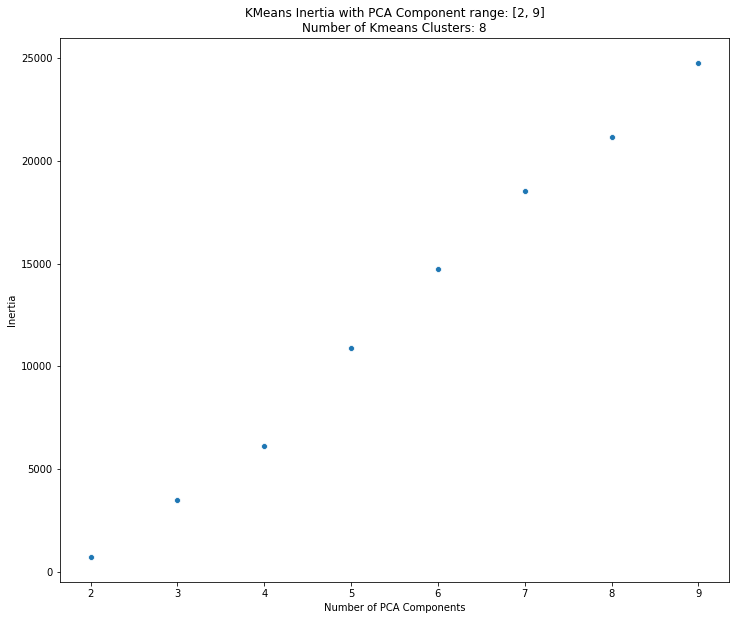

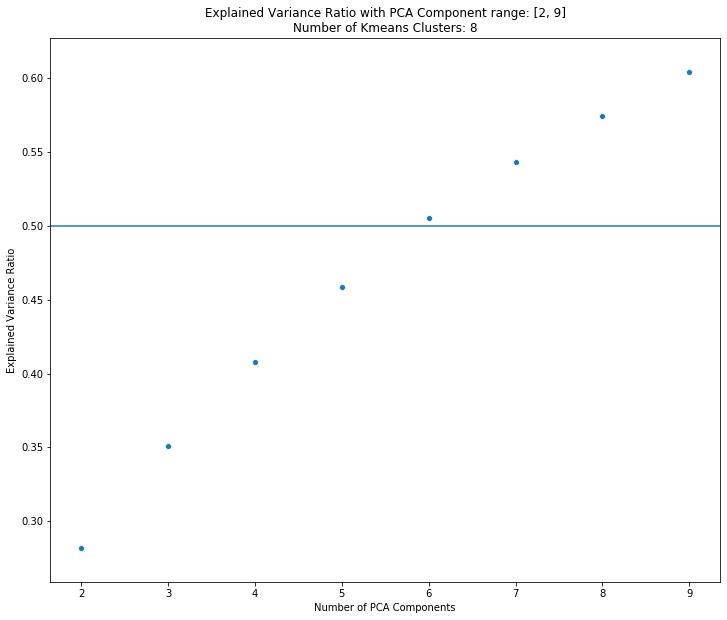

,n_comp,inertia,expl_var_ratio
0,2,710.98,0.281761
1,3,3504.39,0.350853
2,4,6118.31,0.408045
3,5,10880.4,0.458728
4,6,14759,0.505011
5,7,18546.8,0.543049
6,8,21162.5,0.574627
7,9,24768.2,0.604281


In [95]:
pcatest = pd.DataFrame(columns=['n_comp', 'inertia', 'expl_var_ratio'])
n=0
for i in np.arange(2,10):
    inertia, evr = pca_kmean(n_comp=i)
    pcatest.loc[n, 'n_comp'] = i
    pcatest.loc[n, 'inertia'] = inertia
    pcatest.loc[n, 'expl_var_ratio'] = evr.sum()
    n += 1

plt.figure(figsize=(12,10))
sns.scatterplot(data=pcatest, x='n_comp', y='inertia')
plt.xlabel('Number of PCA Components')
plt.ylabel('Inertia')
plt.title('KMeans Inertia with PCA Component range: [2, 9]\nNumber of Kmeans Clusters: 8')
plt.show()
plt.figure(figsize=(12,10))
sns.scatterplot(data=pcatest, x='n_comp', y='expl_var_ratio')
plt.xlabel('Number of PCA Components')
plt.axhline(0.5)
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance Ratio with PCA Component range: [2, 9]\nNumber of Kmeans Clusters: 8')
plt.show()
display(pcatest)

#### Results (Varying N_Components for PCA)

We can see a linear increase in the inertia and explained variance ratio as we increase the components.  This gives us two pieces of information.  Since the `EVR=0.25` for `n_components=2` with a linear increase for each component, we can tell that the data is intrinsically high-dimensional so in order to capture a significant amount of variance we would need a number of components that would defy the whole purpose of PCA to begin with, reducing the dimensions.

Secondly we can tell that as we have more explained variance of data, the inertia also increases linearly, although some increase is to be expected, we'd hope to get clusters with each iteration that can group the observations better.  Adding variance and dimensionality _should_ help the clusters be more separable.

That being said, let's just choose a value of acceptable EVR and move forward.  I arbitrarily set it to 0.5, corresponding to `n_components=6`

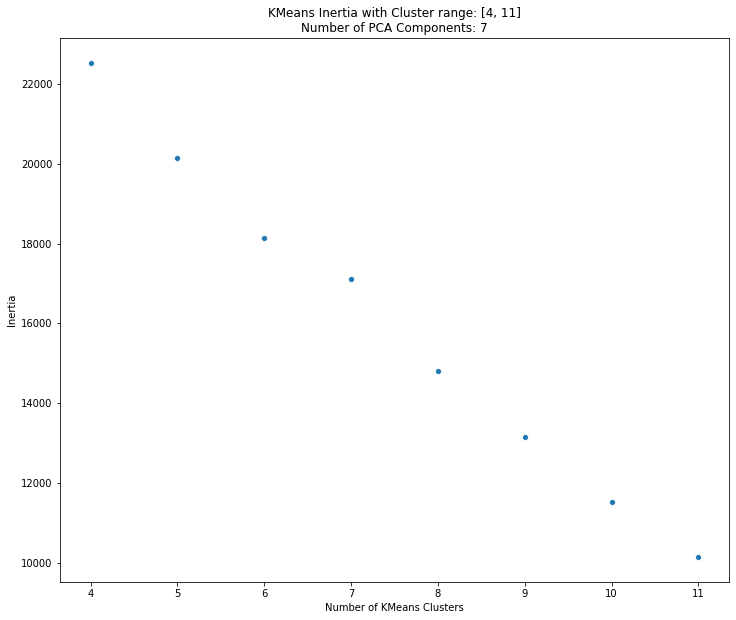

,n_clust,inertia,expl_var_ratio
0,4,22525.7,0.504993
1,5,20133,0.505016
2,6,18127,0.505005
3,7,17118,0.504988
4,8,14801.4,0.505019
5,9,13148.5,0.504919
6,10,11533.1,0.504989
7,11,10144,0.504959


In [96]:
kmtest = pd.DataFrame(columns=['n_clust', 'inertia', 'expl_var_ratio'])
n=0
for i in np.arange(4,12):
    inertia, evr = pca_kmean(n_comp = 6, n_clust=i)
    kmtest.loc[n, 'n_clust'] = i
    kmtest.loc[n, 'inertia'] = inertia
    kmtest.loc[n, 'expl_var_ratio'] = evr.sum()
    n += 1

plt.figure(figsize=(12,10))
sns.scatterplot(data=kmtest, x='n_clust', y='inertia')
plt.xlabel('Number of KMeans Clusters')
plt.ylabel('Inertia')
plt.title('KMeans Inertia with Cluster range: [4, 11]\nNumber of PCA Components: 6')
plt.show()
display(kmtest)

#### Results (Varying N_Clusters for KMeans)

We can see a linear decrease in the inertia as we increase the number of clusters.  This gives us one major piece of information that we can infer through the above data.  The linear decrease would mean that we could eventually get down to an acceptable KMeans inertia, but that would require such a large 'n' number of clusters that would make the purpose clustering the observations meaningless.

Now Let's move onto another method.

### MCA - Heirarchical Clustering

Given that our data is 100% categorical, it makes sense to use MCA and through iterating with `n_components`, we landed on `n_components=5` as the point where additional components no longer added value to the clustering

When `n_clusters` was < 8 the model would just cluster on existing features and > 8 did not split the year-clusters we would want but rather the secondary clusters.  This is what lead me to group at `n_clusters=8`.  The clusters are strongly held on survey year, we may want to drop correction date as a duplicate since it may not be providing any additional information and possibly adding undue weight to a `year` value

In [97]:
dimred_mca = MCA(
    n_components=5,
    n_iter=2,
    copy=True,
    check_input=True,
    engine='auto',
    random_state=36
)

model_agg = AgglomerativeClustering(n_clusters=8, linkage='ward')

pipeline2 = Pipeline([('prepro', prepro), 
                      ('dimred', dimred_mca),
                      ('clustr', model_agg)
                    ])

results2 = enc_df.copy()
results2['labels'] = pipeline2.fit_predict(enc_df)
results2 = pd.concat([loc_df, results2], axis=1)
results2 = results2.loc[:,~results2.columns.duplicated()]

display(
    results2.groupby('labels').mean(),
    results2['labels'].value_counts()
)
for col in list(enc_df.columns) + ['Provider State']:
    ct = pd.crosstab(results2['labels'], results2[col])
    display(ct.style.background_gradient(axis=0))

,Provider Zip Code,Survey Year,Survey Month,Deficiency Prefix,Tag Version,Correction Month,Correction Year,Inspection Cycle,Standard Deficiency,Complaint Deficiency
labels,,,,,,,,,,
0,50932.586586,2016.952987,6.566746,0.998059,0.994609,7.235497,2016.999353,2.893250,0.997628,0.002588
1,53631.084551,2017.894572,6.324008,0.768894,1.000000,5.079123,2018.112317,2.137161,0.996660,0.004593
2,52972.449922,2018.996886,7.045667,0.802543,1.000000,6.635703,2019.142190,1.140114,0.996108,0.003892
3,54974.188787,2019.977117,1.620137,0.784897,1.000000,2.542334,2020.000000,1.000000,0.997712,0.002288
4,46008.274845,2015.992236,8.072981,1.000000,0.737578,9.161491,2016.000000,2.987578,1.000000,0.000000
5,53499.035982,2019.000000,7.389805,0.836582,1.000000,8.546477,2019.000000,1.012744,0.997751,0.002249
6,53040.435793,2017.999185,7.403995,0.809621,1.000000,8.549531,2017.999592,1.977578,0.999185,0.000815
7,53005.131542,2019.000000,3.956153,0.823904,1.000000,5.061528,2019.000000,1.125884,0.992221,0.008487


1    4790
0    4637
2    3854
6    2453
7    1414
5    1334
3     874
4     644
Name: labels, dtype: int64

Survey Year,2015,2016,2017,2018,2019,2020
labels,,,,,,
0,25,168,4444,0,0,0
1,0,0,505,4285,0,0
2,0,0,0,12,3842,0
3,0,0,0,0,20,854
4,5,639,0,0,0,0
5,0,0,0,0,1334,0
6,0,0,2,2451,0,0
7,0,0,0,0,1414,0


Survey Month,1,2,3,4,5,6,7,8,9,10,11,12
labels,,,,,,,,,,,,
0,264,276,363,371,481,484,453,538,479,424,322,182
1,581,548,590,579,490,9,7,11,42,533,620,780
2,544,551,80,14,140,386,11,17,532,649,455,475
3,559,265,30,0,0,0,0,0,0,1,1,18
4,12,16,28,26,39,41,46,90,106,134,82,24
5,1,0,0,0,0,139,599,525,70,0,0,0
6,4,0,3,1,152,546,541,609,520,77,0,0
7,11,3,435,557,404,4,0,0,0,0,0,0


Deficiency Prefix,0,1
labels,,
0,9,4628
1,1107,3683
2,761,3093
3,188,686
4,0,644
5,218,1116
6,467,1986
7,249,1165


Deficiency Category,Construction Deficiencies,Egress Deficiencies,Emergency Preparedness Deficiencies,"Gas, Vacuum, and Electrical Systems Deficiencies",Miscellaneous Deficiencies,Services Deficiencies,Smoke Deficiencies
labels,,,,,,,
0,146,721,9,863,475,315,2108
1,87,576,1107,771,426,197,1626
2,83,451,761,653,344,205,1357
3,17,89,188,139,80,62,299
4,21,53,0,10,421,45,94
5,29,161,218,252,134,66,474
6,51,310,467,385,223,136,881
7,21,192,249,248,145,65,494


Tag Version,0,1
labels,,
0,25,4612
1,0,4790
2,0,3854
3,0,874
4,169,475
5,0,1334
6,0,2453
7,0,1414


Scope Severity Code,C,D,E,F,Misc
labels,,,,,
0,295,1264,1667,1377,34
1,1041,956,1296,1456,41
2,388,948,1116,1376,26
3,51,225,242,348,8
4,34,250,205,146,9
5,111,372,363,478,10
6,438,520,709,761,25
7,124,369,411,500,10


Deficiency Corrected,"Deficient, Provider has date of correction","Deficient, Provider has plan of correction",Misc
labels,,,
0,4581,40,16
1,4644,106,40
2,3709,76,69
3,459,361,54
4,638,6,0
5,1297,37,0
6,2422,29,2
7,1414,0,0


Correction Month,1,2,3,4,5,6,7,8,9,10,11,12
labels,,,,,,,,,,,,
0,161,206,340,337,365,479,451,468,486,530,432,382
1,848,534,647,565,553,616,15,9,3,18,417,565
2,466,417,573,193,13,146,427,14,3,465,580,557
3,117,369,300,30,2,55,1,0,0,0,0,0
4,5,7,19,16,33,38,31,56,86,102,104,147
5,0,0,0,0,0,0,97,549,550,138,0,0
6,4,0,0,1,0,94,526,555,570,585,118,0
7,0,0,0,414,510,479,11,0,0,0,0,0


Correction Year,2015,2016,2017,2018,2019,2020
labels,,,,,,
0,23,2,4595,3,0,14
1,0,0,48,4194,510,38
2,0,0,0,0,3306,548
3,0,0,0,0,0,874
4,0,644,0,0,0,0
5,0,0,0,0,1334,0
6,0,0,1,2452,0,0
7,0,0,0,0,1414,0


Inspection Cycle,1,2,3
labels,,,
0,1,493,4143
1,313,3507,970
2,3321,526,7
3,874,0,0
4,0,8,636
5,1317,17,0
6,111,2286,56
7,1243,164,7


Standard Deficiency,0,1
labels,,
0,11,4626
1,16,4774
2,15,3839
3,2,872
4,0,644
5,3,1331
6,2,2451
7,11,1403


Complaint Deficiency,0,1
labels,,
0,4625,12
1,4768,22
2,3839,15
3,872,2
4,644,0
5,1331,3
6,2451,2
7,1402,12


Provider State,AK,AL,AR,AZ,CA,CO,CT,DC,DE,FL,GA,HI,IA,ID,IL,IN,KS,KY,LA,MA,MD,ME,MI,MN,MO,MS,MT,NC,ND,NE,NH,NJ,NM,NV,NY,OH,OK,OR,PA,PR,RI,SC,SD,TN,TX,UT,VA,VT,WA,WI,WV,WY
labels,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,6,83,17,42,217,0,16,2,6,156,172,2,201,26,410,288,55,25,24,18,95,37,99,89,215,15,47,158,18,134,6,53,26,29,183,241,106,49,297,0,5,23,9,88,414,35,159,3,90,107,26,15
1,4,63,28,45,409,1,28,7,2,195,102,3,159,28,323,339,139,24,19,49,72,53,124,86,242,5,49,133,8,81,13,39,27,63,155,290,121,59,285,0,7,14,11,95,398,23,105,4,142,45,59,15
2,1,48,34,30,324,7,22,2,3,129,39,0,151,6,352,232,81,35,14,47,49,26,157,92,153,9,62,110,7,77,17,32,26,41,122,277,76,35,290,1,4,3,14,72,319,21,48,13,70,43,19,12
3,0,13,8,1,79,0,0,0,0,24,7,0,26,0,157,95,13,4,0,7,5,8,46,13,20,1,2,29,0,15,2,6,5,15,18,79,11,8,21,0,2,1,2,29,61,4,13,2,14,6,2,0
4,5,2,0,9,22,0,1,0,0,26,32,0,50,9,3,13,36,7,0,9,55,0,14,1,4,7,12,6,3,29,0,2,0,2,114,48,20,31,1,0,0,4,0,0,8,11,20,0,7,19,2,0
5,4,18,11,10,100,0,6,1,3,46,14,2,56,0,108,85,26,12,7,31,24,3,51,28,69,2,23,37,5,31,4,10,10,31,47,79,30,9,78,0,1,6,4,26,98,13,21,1,31,12,5,5
6,5,27,18,26,164,0,19,2,0,85,44,0,84,13,174,150,37,12,19,23,31,31,70,43,135,1,53,85,12,59,4,19,21,39,82,147,60,22,164,1,4,10,0,53,207,18,67,1,69,26,14,3
7,0,16,12,13,106,1,6,1,1,62,15,0,34,2,110,95,40,11,14,13,19,11,62,41,67,5,12,29,2,22,2,16,8,17,45,98,22,10,91,0,1,5,5,33,130,12,45,1,33,14,4,0


### Geoplot

Below I'm creating a loop for each year and exporting the static images to create a gif

In [113]:
for year in np.arange(2015, 2021):
    filename=f"data/{year}_clustrimg.png"
    plotdf = results2[results2['Survey Year'] == year]
    plotdf = plotdf[['Lat', 'Long', 'Deficiency Category', 'labels']]
    fig = go.Figure(
        data=go.Scattergeo(
            lon=plotdf['Long'],
            lat=plotdf['Lat'],
            text=plotdf['Deficiency Category'],
            mode='markers',
            marker_color=plotdf['labels'],
            marker_opacity=0.3
        )
    )
    fig.update_layout(
        title = f'{year} Deficiency cluster distribution', 
        geo_scope='usa',
                     )
    fig.write_image(filename)

## Conclusion

There is a lack of standardization in the years prior to 2017 and we're essentially seeing that the aggregated feature value is the main defining point for the early years, 2020 has the most open, unresolved deficiencies, but that's to be expected since it's the current year with not much time for the deficiency to be corrected.  `Correction Date` should be dropped and a feature added of `Time Open` as the time differential from the survey to the correction date to prevent the double weight on year and secondary weight on month.  This might open up the clusters to form on some more meaningful shape.  I may also drop the thresholds for aggregating since it seems that the aggregated misc value defines the clusters more that we would like.  Overall the clusters are performing well with MCA and with some added features and minor fixes we should be able to deduce more meaningful results.

### Future:

1. incorporate census data for each location for more clustering parameters

2. incorporate weather data to see whether temp/humidity play more of a role in the deficiencies than the clusters we see corresponding to month/location

In [ ]:
# US CENSUS API FOR DEMOGRAPHICS
# https://www.census.gov/data/developers/data-sets.html
f=open("data/uscensusapikey.txt","r");key=f.read();f.close();key=None